In [1]:
# import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
		'Cannot communicate with GPU. '
		'Make sure you are using a GPU Colab runtime. '
		'Go to the Runtime menu and select Choose runtime type.')
print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=egl
import os
os.environ['MUJOCO_GL']='glx'
os.environ['PYOPENGL_PLATFORM'] = 'glx'


if "MUJOCO_GL" in os.environ:
    print(os.getenv('MUJOCO_GL'))
    print(os.getenv('PYOPENGL_PLATFORM'))
    
# try:
# 	print('Checking that the installation succeeded:')
import mujoco
# 	mujoco.MjModel.from_xml_string('<mujoco/>')
# except Exception as e:
#   raise e from RuntimeError(
# 		'Something went wrong during installation. Check the shell output above '
# 		'for more information.\n'
# 		'If using a hosted Colab runtime, make sure you enable GPU acceleration '
# 		'by going to the Runtime menu and selecting "Choose runtime type".')
print('Installation successful.')    
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List
# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt
# More legible printing from numpy.glx
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Tue Jan 17 17:37:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
|  0%   52C    P5    40W / 170W |   1026MiB / 12020MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

""

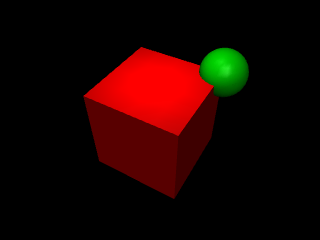

In [3]:
model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

time  0.0015012209914857522
time  0.0008496719965478405
time  0.0006099099991843104
time  0.0011925590079044923
time  0.000719746996765025
time  0.0008118209952954203
time  0.0007561859965790063
time  0.0005473420023918152
time  0.0005381049995776266
time  0.0005495369987329468


""

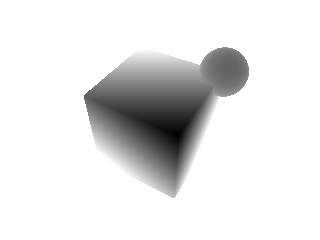

In [4]:
# update renderer to render depth
renderer.enable_depth_rendering()

# reset the scene
start = time.monotonic()
for _ in range(10):
  renderer.update_scene(data)

  # depth is a float array, in meters.
  depth = renderer.render()
  print("time ", time.monotonic()-start)
  start = time.monotonic()
# Shift nearest values to the origin.
depth -= depth.min()
# Scale by 2 mean distances of near rays.
depth /= 2*depth[depth <= 1].mean()
# Scale to [0, 255]
pixels = 255*np.clip(depth, 0, 1)

media.show_image(pixels.astype(np.uint8))

renderer.disable_depth_rendering()